# Estimating the Impact of the 2007 Maternity Capital Policy in Russia using the Synthetic Control Method

## Overview of the Maternity Capital Policy

- The Maternity Capital (MC) policy was announced in President Vladimir’s Putin’s annual address to the Federal Assembly on 10 May 2006.
- The MC policy was launched to tackle population decline
- The Federal Law of the Russian Federation No. 256-FZ “On Additional Measures of State Support of Families with Children” provides “maternity capital” assistance to families with children, which is available in the event of a birth or adoption of a second or higher order child between January 1, 2007 and December 31, 2016 (after being extended multiple times, the deadline is now the end of 2026)
- Initially set at 250,000 rubles, can be put towards improving housing conditions, education, or the mother’s pension, and can only be received once

![Image of Russian Family](https://cdni.rbth.com/rbthmedia/images/2020.03/original/5e746e5085600a0b020c95d1.jpg)

## Overview of the Synthetic Control Method (SCM)
SCM can be used to estimate the effect of an intervention (the MC policy in this case) in comparative case studies. A 'synthetic control', a weighted combination of groups used as controls, is compared to the treatment group to estimate the impact of the intervention.

## Overview of Analysis
I created a Synthetic Control using other Post-Soviet states as controls for Russia to estimate the impact of the Maternity Capital Policy on fertility rates. The weights for Synthetic Russia are shown in the bar chart below

![Image of Impact](MC_SCM_Weights.png)

## Results
Based on this analysis, the MC policy appears to have caused an increase in Russia's Total Fertility Rate (TFR) by approximately 0.15 births per woman on average between 2007 and 2019. 

![Image of Impact](MC_Policy_SCM.png)

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np

import yaml

from fredapi import Fred

import datetime as dt

from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn import linear_model

In [2]:
sns.set_palette('Set2')

In [3]:
# You will need to get your own API key from FRED

config = open("config.yaml")
parsed_yaml = yaml.load(config, Loader=yaml.FullLoader)

fred_api_key = parsed_yaml['fred_api']

fred = Fred(api_key=fred_api_key)

## Importing Data

In [4]:
# Importing fertility rate data from FRED

armenia = fred.get_series_latest_release('SPDYNTFRTINARM')
azerbaijan = fred.get_series_latest_release('SPDYNTFRTINAZE')
belarus = fred.get_series_latest_release('SPDYNTFRTINBLR')
estonia = fred.get_series_latest_release('SPDYNTFRTINEST')
georgia = fred.get_series_latest_release('SPDYNTFRTINGEO')
kazakhstan = fred.get_series_latest_release('SPDYNTFRTINKAZ')
kyrgyzstan = fred.get_series_latest_release('SPDYNTFRTINKGZ')
latvia = fred.get_series_latest_release('SPDYNTFRTINLVA')
lithuania = fred.get_series_latest_release('SPDYNTFRTINLTU')
moldova = fred.get_series_latest_release('SPDYNTFRTINMDA')
russia = fred.get_series_latest_release('SPDYNTFRTINRUS')
tajikistan = fred.get_series_latest_release('SPDYNTFRTINTJK')
turkmenistan = fred.get_series_latest_release('SPDYNTFRTINTKM')
ukraine = fred.get_series_latest_release('SPDYNTFRTINUKR')
uzbekistan = fred.get_series_latest_release('SPDYNTFRTINUZB')

## Setting up Dataset

In [5]:
frame = {'Armenia' : armenia,
        'Azerbaijan' : azerbaijan,
        'Belarus' : belarus,
        'Estonia' : estonia,
        'Georgia' : georgia,
        'Kazakhstan' : kazakhstan,
        'Kyrgyzstan' : kyrgyzstan,
        'Latvia' : latvia,
        'Lithuania' : lithuania,
        'Moldova' : moldova,
        'Russia' : russia,
        'Tajikistan' : tajikistan,
        'Turkmenistan' : turkmenistan,
        'Ukraine' : ukraine,
        'Uzbekistan' : uzbekistan}

In [6]:
fertility_df = pd.DataFrame(frame)

In [7]:
fertility_df = pd.DataFrame(frame)
fertility_df = fertility_df.dropna()
fertility_df.reset_index(level=0, inplace=True)
fertility_df = fertility_df.rename(columns={'index':'date'})

In [8]:
fertility_long_df = pd.melt(fertility_df, id_vars=['date'],
                           var_name='country', value_name = 'tfr')
fertility_long_df['russia'] = np.where(fertility_long_df['country']=='Russia', True, False)
fertility_long_df['after_treatment'] = np.where(fertility_long_df['date']>='2007-01-01', True, False)

## Showing Russia vs. Post Soviet States
The chart below compares the evolution of fertility rates in Russia to the evolution in fertility rates for a simple average of other Post-Soviet states.

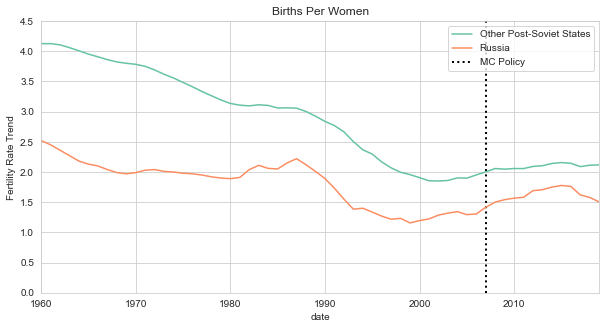

In [9]:
sns.set_style('whitegrid')

ax = plt.subplot(1, 1, 1)

(fertility_long_df
 .assign(russia = np.where(fertility_long_df["russia"], "Russia", "Other Post-Soviet States"))
 .groupby(["date", "russia"])
 ["tfr"]
 .mean()
 .reset_index()
 .pivot("date", "russia", "tfr")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x='2007-01-01', ymin=0, ymax=4.5, linestyle=":", lw=2, label="MC Policy")
plt.ylabel("Fertility Rate Trend")
plt.title("Births Per Women")
plt.ylim([0, 4.5])
plt.legend();  

## Implementing the Synthetic Control Method
Using Lasso to estimate weights for Synthetic Russia.

Synthetic Russia is a combination of:

- 23.6% Estonia
- 22.6% Kazakhstan
- 17.7% Moldova
- 16.3% Latvia

In [10]:
features = ["tfr"]

inverted = (fertility_long_df.query("~after_treatment") # filter pre-intervention period
            .pivot(index='country', columns="date")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state


In [11]:
y = inverted['Russia'].values # state of california
X = inverted.drop(columns=['Russia']).values  # other states

In [12]:
from sklearn.linear_model import LassoCV
weights_lr = LassoCV(fit_intercept=False).fit(X, y).coef_

/Users/stellam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022169315689449964, tolerance: 0.0162433591
  model = cd_fast.enet_coordinate_descent(


In [13]:
weights_display = pd.DataFrame({'Region': [region for region in list(inverted.columns) if region != 'Russia'],
                              'Weights': weights_lr.round(10).tolist()}) 

weights_display = weights_display.sort_values(by=['Weights'], ascending=False)

In [14]:
print(weights_display)

          Region   Weights
3        Estonia  0.236181
5     Kazakhstan  0.225904
9        Moldova  0.176812
7         Latvia  0.162844
0        Armenia  0.000000
1     Azerbaijan -0.000000
2        Belarus  0.000000
4        Georgia  0.000000
6     Kyrgyzstan  0.000000
8      Lithuania  0.000000
10    Tajikistan  0.000000
11  Turkmenistan -0.000000
12       Ukraine  0.000000
13    Uzbekistan -0.000000


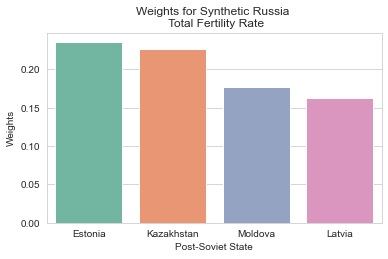

In [15]:
fig, ax = plt.subplots(figsize=(6, 3.5))

g = sns.barplot(data=weights_display.head(4), x='Region', y='Weights')
g.set(xlabel='Post-Soviet State', title='Weights for Synthetic Russia \n Total Fertility Rate')

fig.savefig('MC_SCM_Weights.png', dpi=500)

In [16]:
russia_synth_lr = (fertility_long_df.query("~russia")
                  .pivot(index='date', columns="country")["tfr"]
                  .values.dot(weights_lr))

## Showing Synthetic Russia
The SCM suggests that the MC Policy caused Russian Fertility to increase from 2006 levels of 1.3 births per woman. The actual average TFR (total fertility rate) between 2007 and 2019 in Russia was 1.62, as opposed to the average of Synthetic Russia of 1.47. 

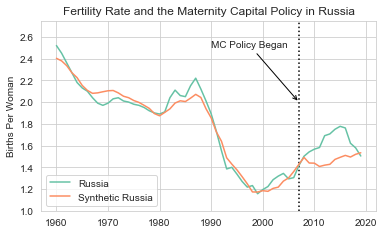

In [17]:
fig, ax = plt.subplots(figsize=(6, 3.5))

plt.plot(fertility_long_df.query("russia")["date"], fertility_long_df.query("russia")["tfr"], label="Russia")
plt.plot(fertility_long_df.query("russia")["date"], russia_synth_lr, label="Synthetic Russia")

plt.vlines(x=dt.datetime(2007, 1, 1), ymin = 1, ymax = 2.75, linestyles=':')

plt.ylabel("Births Per Woman")
plt.title("Fertility Rate and the Maternity Capital Policy in Russia")

ax.set_ylim([1, 2.75])

ax.annotate('MC Policy Began', xy=(dt.datetime(2007, 1, 1), 2),
           xytext = (dt.datetime(1990, 1, 1), 2.5),
           arrowprops=dict(arrowstyle='->', color='black'))

plt.legend(loc = 'lower left')

fig.savefig('MC_Policy_SCM.png', dpi=500)

In [18]:
synth_df = pd.DataFrame({'after_treatment': fertility_long_df.query("russia")["after_treatment"], 
              'tfr': russia_synth_lr})

In [19]:
synth_df = pd.DataFrame({'after_treatment': fertility_long_df.query("russia")["after_treatment"], 
              'tfr': russia_synth_lr})

In [20]:
print('Russia Actual Fertility Rate 2006:', fertility_long_df[(fertility_long_df['country']=='Russia')&
                                                             (fertility_long_df['date']=='2006-01-01')\
                                                             ].iloc[0]['tfr'])

print('Russia Actual Avg. Fertiilty Post 2007: ', 
      round(fertility_long_df[(fertility_long_df['country']=='Russia')&
                        (fertility_long_df['after_treatment']==True)]['tfr'].mean(), 2))
      
print('Synthetic Russia Avg. Fertility Post 2007: ', round(synth_df[(synth_df['after_treatment']==True)]\
                                                           ['tfr'].mean(), 2))

Russia Actual Fertility Rate 2006: 1.305
Russia Actual Avg. Fertiilty Post 2007:  1.62
Synthetic Russia Avg. Fertility Post 2007:  1.47
